# 🏭 Smart Industrial Maintenance System — GPU Training Notebook

**FSE 570 Capstone** | Arizona State University

This notebook runs the complete training pipeline on Google Colab with GPU acceleration.

---

## 1. Setup Environment

In [ ]:
# Check GPU availability
import torch
print(f"PyTorch: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    props = torch.cuda.get_device_properties(0)
    vram = getattr(props, 'total_memory', getattr(props, 'total_mem', 0))
    print(f"VRAM: {vram / 1e9:.1f} GB")

PyTorch: 2.10.0+cu128
CUDA available: True
GPU: NVIDIA L4
VRAM: 23.7 GB


In [ ]:
# Install dependencies
!pip install -q xgboost lifelines shap pulp

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 350.0/350.0 kB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 13.0 MB/s eta 0:00:00


In [ ]:
# Clone your project repo
!git clone https://github.com/SivaKanth007/Capstone-Project.git
%cd Capstone-Project

Cloning into 'Capstone-Project'...
remote: Enumerating objects: 73, done.
remote: Counting objects: 100% (73/73), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 73 (delta 21), reused 70 (delta 18), pack-reused 0 (from 0)
Receiving objects: 100% (73/73), 930.11 KiB | 26.57 MiB/s, done.
Resolving deltas: 100% (21/21), done.
/content/Capstone-Project


## 2. Download & Preprocess Data

The download module will automatically try direct download first — **no Kaggle credentials needed**.
If the direct download fails, it falls back to a synthetic data generator.

In [ ]:
import os
import numpy as np
import config
from src.data.download import download_cmapss, load_cmapss_train
from src.data.preprocess import DataPreprocessor
from src.data.feature_engineering import FeatureEngineer
from src.data.synthetic_generator import SyntheticDataGenerator

# Download C-MAPSS dataset (direct URL, no auth)
download_cmapss()
df_train = load_cmapss_train()
print(f"\nTraining data: {df_train.shape}")
df_train.head()

[CONFIG] Using device: cuda
[CONFIG] GPU: NVIDIA L4
[CONFIG] VRAM: 23.7 GB
[DOWNLOAD] Attempting direct download (no authentication required)...
[DOWNLOAD] Downloading from: https://phm-datasets.s3.amazonaws.com/NASA/6.+Turbofan+Engine+Degradation+Simula...
[DOWNLOAD] Progress: 100% (12.4 MB)
[DOWNLOAD] Extracting...
[DOWNLOAD] Extracting nested zip: CMAPSSData.zip
[DOWNLOAD] Direct download successful!
[DOWNLOAD] Available files:
  - Damage Propagation Modeling.pdf (0.43 MB)
  - RUL_FD001.txt (0.00 MB)
  - RUL_FD002.txt (0.00 MB)
  - RUL_FD003.txt (0.00 MB)
  - RUL_FD004.txt (0.00 MB)
  - readme.txt (0.00 MB)
  - test_FD001.txt (2.23 MB)
  - test_FD002.txt (5.73 MB)
  - test_FD003.txt (2.83 MB)
  - test_FD004.txt (6.96 MB)
  - train_FD001.txt (3.52 MB)
  - train_FD002.txt (9.08 MB)
  - train_FD003.txt (4.21 MB)
  - train_FD004.txt (10.35 MB)
[DOWNLOAD] Loading training data from: /content/Capstone-Project/data/raw/train_FD001.txt
[DOWNLOAD] Loaded 20631 rows, 100 units
[DOWNLOAD] Cycl

,unit_id,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,125
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,125
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,125
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,125
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,125


In [ ]:
# Generate synthetic data
gen = SyntheticDataGenerator()
logs, context, schedule = gen.generate_all(df_train)
print(f"Maintenance logs: {logs.shape}")
print(f"Operational context: {context.shape}")

Generating Synthetic Industrial Data
[SYNTHETIC] Generated 444 maintenance logs for 100 units
  Planned: 292 | Unplanned: 152
  Total cost: $4,030,800
[SYNTHETIC] Generated operational context for 100 units

[SYNTHETIC] All data saved to /content/Capstone-Project/data/synthetic
Maintenance logs: (444, 8)
Operational context: (100, 9)


In [ ]:
# Feature engineering (for XGBoost)
fe = FeatureEngineer()
df_engineered = fe.engineer_features(df_train.copy())
print(f"Engineered features: {df_engineered.shape}")

Running Feature Engineering Pipeline
[FEATURES] Added cycle_norm and cycle_squared features


/content/Capstone-Project/src/data/feature_engineering.py:67: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col_name] = series
/content/Capstone-Project/src/data/feature_engineering.py:67: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col_name] = series
/content/Capstone-Project/src/data/feature_engineering.py:67: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) inst

[FEATURES] Added 168 rolling features (3 windows × 4 stats × 14 sensors)


/content/Capstone-Project/src/data/feature_engineering.py:106: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col_name] = series
/content/Capstone-Project/src/data/feature_engineering.py:106: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col_name] = series
/content/Capstone-Project/src/data/feature_engineering.py:106: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) i

[FEATURES] Added 14 trend features


/content/Capstone-Project/src/data/feature_engineering.py:129: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["operating_regime"] = self.regime_model.fit_predict(df[op_cols])
/content/Capstone-Project/src/data/feature_engineering.py:157: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col_name] = np.nan
/content/Capstone-Project/src/data/feature_engineering.py:157: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining

[FEATURES] Clustered 2 settings into 3 regimes:
  Regime 0: 5208 observations (25.2%)
  Regime 1: 5800 observations (28.1%)
  Regime 2: 9623 observations (46.6%)
[FEATURES] Added 42 lag features (3 lags × 14 sensors)
[FEATURES] Added 20 interaction features from top-5 sensors

[FEATURES] Total features: 27 → 274 (+247 engineered)
Engineered features: (20631, 274)


/content/Capstone-Project/src/data/feature_engineering.py:163: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[lag_cols] = df[lag_cols].fillna(method="bfill").fillna(0)
/content/Capstone-Project/src/data/feature_engineering.py:183: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{s1}_x_{s2}"] = df[s1] * df[s2]
/content/Capstone-Project/src/data/feature_engineering.py:184: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{s1}_div_{s2

In [ ]:
# Preprocessing pipeline (for LSTM models)
preprocessor = DataPreprocessor()
data = preprocessor.fit_transform(df_train)
preprocessor.save()

for split_name, split_data in data.items():
    np.savez_compressed(
        os.path.join(config.PROCESSED_DATA_DIR, f"{split_name}_data.npz"),
        **split_data
    )

X_train = data['train']['X']
y_train_rul = data['train']['y_rul']
y_train_binary = data['train']['y_binary']
X_val = data['val']['X']
y_val_binary = data['val']['y_binary']

n_features = X_train.shape[2]
print(f"Sequences: {X_train.shape}, Features: {n_features}")

Running Full Preprocessing Pipeline
[PREPROCESS] Dropped 9 constant columns: ['sensor_1', 'sensor_5', 'sensor_6', 'sensor_10', 'sensor_16', 'sensor_18', 'sensor_19', 'op_setting_3', 'op_setting_2']
[PREPROCESS] No missing values detected
[PREPROCESS] Split: train=70 units (14316 rows), val=15 units (3170 rows), test=15 units (3145 rows)
[PREPROCESS] Fitted scaler on 15 features
[PREPROCESS] Created 12286 sequences of shape (30, 15)
[PREPROCESS] train: X=(12286, 30, 15), y_rul range=[0, 125], failure_rate=17.66%
[PREPROCESS] Created 2735 sequences of shape (30, 15)
[PREPROCESS] val: X=(2735, 30, 15), y_rul range=[0, 125], failure_rate=17.00%
[PREPROCESS] Created 2710 sequences of shape (30, 15)
[PREPROCESS] test: X=(2710, 30, 15), y_rul range=[0, 125], failure_rate=17.16%
[PREPROCESS] Saved preprocessor to /content/Capstone-Project/models/saved/preprocessor.pkl
Sequences: (12286, 30, 15), Features: 15


## 3. Train LSTM Autoencoder (Anomaly Detection)

In [ ]:
from src.models.autoencoder import LSTMAutoencoder, AutoencoderTrainer

# Train on healthy data only
healthy_mask = y_train_rul > config.MAX_RUL * 0.5
X_healthy = X_train[healthy_mask]
X_val_ae = X_val[data['val']['y_rul'] > config.MAX_RUL * 0.5]

print(f"Training autoencoder on {len(X_healthy)} healthy samples")
print(f"Device: {config.DEVICE}")

autoencoder = LSTMAutoencoder(input_dim=n_features)
ae_trainer = AutoencoderTrainer(autoencoder, epochs=50)
ae_trainer.train(X_healthy, X_val_ae)
ae_trainer.save_model()

Training autoencoder on 7876 healthy samples
Device: cuda

[AUTOENCODER] Training on cuda (7876 samples, 50 epochs)
  Epoch 1/50 — Train Loss: 0.031796 | Val Loss: 0.010391
  Epoch 5/50 — Train Loss: 0.010042 | Val Loss: 0.009886
  Epoch 10/50 — Train Loss: 0.005739 | Val Loss: 0.005600
  Epoch 15/50 — Train Loss: 0.005697 | Val Loss: 0.005642
  Epoch 20/50 — Train Loss: 0.005491 | Val Loss: 0.005441
  Epoch 25/50 — Train Loss: 0.005476 | Val Loss: 0.005428
  Epoch 30/50 — Train Loss: 0.005467 | Val Loss: 0.005477
  Epoch 35/50 — Train Loss: 0.005453 | Val Loss: 0.005420
  Epoch 40/50 — Train Loss: 0.005446 | Val Loss: 0.005402
  Epoch 45/50 — Train Loss: 0.005447 | Val Loss: 0.005400
  Epoch 50/50 — Train Loss: 0.005443 | Val Loss: 0.005405
[AUTOENCODER] Restored best model (val_loss=0.005400)
[AUTOENCODER] Threshold set: 0.006792 (mean=0.005428, std=0.000455)
[AUTOENCODER] Model saved to /content/Capstone-Project/models/saved/autoencoder.pt


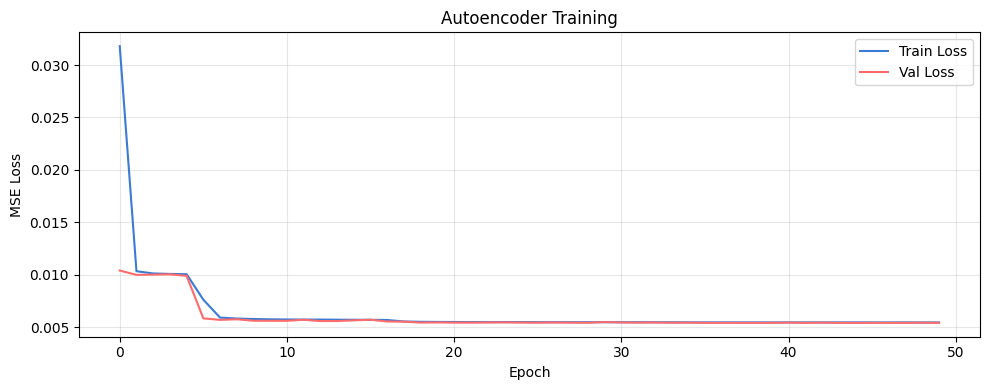

In [ ]:
# Visualize training loss
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(ae_trainer.train_history, label='Train Loss', color='#3a7bd5')
if ae_trainer.val_history:
    ax.plot(ae_trainer.val_history, label='Val Loss', color='#FF6B6B')
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE Loss')
ax.set_title('Autoencoder Training')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 4. Train LSTM Failure Predictor

In [ ]:
from src.models.lstm_predictor import LSTMPredictor, PredictorTrainer

predictor = LSTMPredictor(input_dim=n_features)
pred_trainer = PredictorTrainer(predictor, epochs=50)
pred_trainer.train(X_train, y_train_binary, X_val, y_val_binary)
pred_trainer.save_model()


[PREDICTOR] Training on cuda (12286 samples, pos_rate=17.66%)
[PREDICTOR] Positive weight: 4.66
  Epoch 5/50 — Loss: 0.1978 | F1: 0.8705 | AUC: 0.9944 | Prec: 0.7720 | Rec: 0.9978
  Epoch 10/50 — Loss: 0.1615 | F1: 0.8923 | AUC: 0.9947 | Prec: 0.9031 | Rec: 0.8817
  Epoch 15/50 — Loss: 0.1555 | F1: 0.8937 | AUC: 0.9934 | Prec: 0.9537 | Rec: 0.8409
  Epoch 20/50 — Loss: 0.1521 | F1: 0.8913 | AUC: 0.9966 | Prec: 0.9895 | Rec: 0.8108
  Epoch 25/50 — Loss: 0.1466 | F1: 0.9161 | AUC: 0.9957 | Prec: 0.8840 | Rec: 0.9505
  Epoch 30/50 — Loss: 0.1480 | F1: 0.9205 | AUC: 0.9970 | Prec: 0.9456 | Rec: 0.8968
  Epoch 35/50 — Loss: 0.1435 | F1: 0.8939 | AUC: 0.9951 | Prec: 0.8228 | Rec: 0.9785
  Epoch 40/50 — Loss: 0.1195 | F1: 0.9023 | AUC: 0.9951 | Prec: 0.8485 | Rec: 0.9634
  Epoch 45/50 — Loss: 0.1251 | F1: 0.8873 | AUC: 0.9953 | Prec: 0.8271 | Rec: 0.9570
  Epoch 50/50 — Loss: 0.1075 | F1: 0.8813 | AUC: 0.9910 | Prec: 0.8280 | Rec: 0.9419
[PREDICTOR] Restored best model (F1=0.9205)
[PREDICTOR

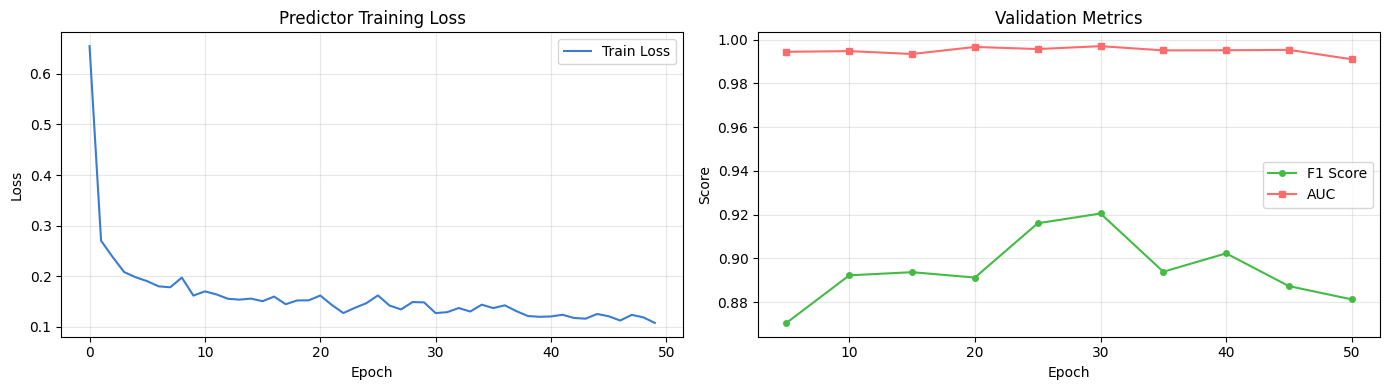

In [ ]:
# Visualize predictor training
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

ax1.plot(pred_trainer.train_history, label='Train Loss', color='#3a7bd5')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Predictor Training Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

if pred_trainer.val_history:
    epochs_list = range(5, len(pred_trainer.val_history) * 5 + 1, 5)
    f1s = [m.get('f1', 0) for m in pred_trainer.val_history]
    aucs = [m.get('auc', 0) for m in pred_trainer.val_history]
    ax2.plot(epochs_list, f1s, label='F1 Score', color='#44BB44', marker='o', markersize=4)
    ax2.plot(epochs_list, aucs, label='AUC', color='#FF6B6B', marker='s', markersize=4)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Score')
    ax2.set_title('Validation Metrics')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Train XGBoost RUL Model

In [ ]:
from src.models.xgboost_rul import XGBoostRUL

exclude_cols = ['unit_id', 'cycle', 'RUL']
feature_cols = [c for c in df_engineered.columns if c not in exclude_cols]

unit_ids = df_engineered['unit_id'].unique()
np.random.seed(config.RANDOM_SEED)
np.random.shuffle(unit_ids)
n = len(unit_ids)
train_units = unit_ids[:int(n * 0.7)]
val_units = unit_ids[int(n * 0.7):int(n * 0.85)]

X_train_xgb = df_engineered[df_engineered['unit_id'].isin(train_units)][feature_cols]
y_train_xgb = df_engineered[df_engineered['unit_id'].isin(train_units)]['RUL'].values
X_val_xgb = df_engineered[df_engineered['unit_id'].isin(val_units)][feature_cols]
y_val_xgb = df_engineered[df_engineered['unit_id'].isin(val_units)]['RUL'].values

xgb_model = XGBoostRUL()
xgb_model.train(X_train_xgb, y_train_xgb, X_val_xgb, y_val_xgb,
                feature_names=feature_cols)
xgb_model.evaluate(X_val_xgb, y_val_xgb)
xgb_model.save()

[XGBOOST] Training with 271 features, 14316 samples
[0]	validation_0-rmse:37.76259	validation_1-rmse:37.70108
[10]	validation_0-rmse:15.11130	validation_1-rmse:16.34023
[20]	validation_0-rmse:7.84960	validation_1-rmse:11.23845
[30]	validation_0-rmse:5.56914	validation_1-rmse:10.40084
[40]	validation_0-rmse:4.48907	validation_1-rmse:10.31719
[50]	validation_0-rmse:3.78393	validation_1-rmse:10.35087
[60]	validation_0-rmse:3.27735	validation_1-rmse:10.35471
[70]	validation_0-rmse:2.91001	validation_1-rmse:10.37957
[80]	validation_0-rmse:2.66264	validation_1-rmse:10.37784
[90]	validation_0-rmse:2.42638	validation_1-rmse:10.39447
[100]	validation_0-rmse:2.22308	validation_1-rmse:10.38635
[110]	validation_0-rmse:2.03233	validation_1-rmse:10.39012
[120]	validation_0-rmse:1.88518	validation_1-rmse:10.42063
[130]	validation_0-rmse:1.75594	validation_1-rmse:10.41732
[140]	validation_0-rmse:1.65161	validation_1-rmse:10.41606
[150]	validation_0-rmse:1.55980	validation_1-rmse:10.41524
[160]	validat

## 6. Bayesian Survival Analysis

In [ ]:
from src.models.bayesian_survival import BayesianSurvival

survival_features = config.ACTIVE_SENSORS + ['cycle']
survival_cols = [c for c in survival_features if c in df_train.columns] + ['RUL']

df_survival_train = df_train[df_train['unit_id'].isin(train_units)][['unit_id'] + survival_cols]

survival_model = BayesianSurvival()
survival_model.fit(df_survival_train)

df_survival_val = df_train[df_train['unit_id'].isin(val_units)][['unit_id'] + survival_cols]
survival_model.evaluate(df_survival_val)
survival_model.save()

[SURVIVAL] Preparing survival data...
[SURVIVAL] Fitting Weibull AFT model with 14 covariates, 14316 observations
[SURVIVAL] Event rate: 2.93%
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.08918053283272795
            Iterations: 74
            Function evaluations: 84
            Gradient evaluations: 74
     message: Optimization terminated successfully
     success: True
      status: 0
         fun: 0.08918053283272795
           x: [-1.037e+00  8.840e-01 ...  1.699e+01  1.868e-01]
         nit: 74
         jac: [-2.601e-06 -8.623e-06 ... -2.677e-07  6.169e-08]
        nfev: 84
        njev: 74
 multipliers: []

[SURVIVAL] Model Summary:


<lifelines.WeibullAFTFitter: fitted with 14316 total observations, 13896 right-censored observations>
             duration col = 'duration'
                event col = 'event'
   number of observations = 14316
number of events observed = 420
           log-likelihood = -1276.709
         time fit was run = 2026-02-19 22:46:07 UTC

---
                     coef exp(coef)       p
param   covariate                          
lambda_ sensor_11  -3.908     0.020 <0.0005
        sensor_12   1.209     3.349 <0.0005
        sensor_13  -0.007     0.993   0.995
        sensor_14   0.011     1.011   0.229
        sensor_15 -11.112     0.000 <0.0005
        sensor_17  -0.144     0.866   0.001
        sensor_2   -0.556     0.574 <0.0005
        sensor_20   2.678    14.552 <0.0005
        sensor_21   3.459    31.786 <0.0005
        sensor_3   -0.043     0.958 <0.0005
        sensor_4   -0.084     0.920 <0.0005
        sensor_7    0.786     2.195 <0.0005
        sensor_8   -0.094     0.910   0.935
        sensor_9   -0.025     0.976   0.003
        Intercept  16.992 2.396e+07   0.995
rho_    Intercept   0.187     1.205 <0.0005
---
Concordance = 0.992
AIC = 2585.417
log-likelihood ratio test = 3816.235 on 14 df
-log2(p) of ll-ratio test = inf


[SURVIVAL] Evaluation Results:
  C-Index: 0.9921
  RMSE (failures only): 34.26
  Events: 90 | Censored: 3080
[SURVIVAL] Model saved to /content/Capstone-Project/models/saved/bayesian_survival.pkl


## 7. Explainability (SHAP & Attention)

In [ ]:
from src.explainability.shap_analysis import SHAPExplainer

# SHAP for XGBoost
shap_explainer = SHAPExplainer(xgb_model, model_type='xgboost')
shap_explainer.compute_shap_values(X_val_xgb)
shap_explainer.plot_global_importance(save_path='shap_importance.png')
shap_explainer.plot_beeswarm(save_path='shap_beeswarm.png')
ranking = shap_explainer.get_sensor_ranking()
ranking.head(15)

[SHAP] TreeExplainer initialized for XGBoost
[SHAP] Computing SHAP values for 500 samples...
[SHAP] SHAP values computed successfully


/content/Capstone-Project/src/explainability/shap_analysis.py:106: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


[SHAP] Saved importance plot to shap_importance.png


/content/Capstone-Project/src/explainability/shap_analysis.py:130: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


[SHAP] Saved beeswarm plot to shap_beeswarm.png

[SHAP] Sensor Ranking (Top 15):
             feature  mean_abs_shap
          cycle_norm      26.437468
       cycle_squared       6.633072
sensor_14_roll20_max       0.971623
 sensor_9_roll20_min       0.570310
 sensor_2_roll20_min       0.540071
sensor_15_roll20_max       0.504612
 sensor_4_roll20_min       0.476033
 sensor_8_roll20_max       0.444286
 sensor_7_roll20_min       0.385149
 sensor_9_roll20_max       0.378528
 sensor_9_roll20_std       0.341212
 sensor_2_roll20_max       0.338147
sensor_21_roll20_max       0.331748
 sensor_4_roll10_min       0.301579
sensor_20_roll20_min       0.299422


,feature,mean_abs_shap
0,cycle_norm,26.437468
1,cycle_squared,6.633072
2,sensor_14_roll20_max,0.971623
3,sensor_9_roll20_min,0.570310
4,sensor_2_roll20_min,0.540071
5,sensor_15_roll20_max,0.504612
6,sensor_4_roll20_min,0.476033
7,sensor_8_roll20_max,0.444286
8,sensor_7_roll20_min,0.385149
9,sensor_9_roll20_max,0.378528


In [ ]:
from src.explainability.attention_viz import AttentionVisualizer

# Attention visualization
attn_viz = AttentionVisualizer(predictor)
attn_viz.plot_attention_heatmap(data['test']['X'], save_path='attention_heatmap.png')
attn_viz.plot_average_attention(data['test']['X'], data['test']['y_binary'],
                                save_path='attention_comparison.png')

[ATTENTION] Saved heatmap to attention_heatmap.png
[ATTENTION] Saved comparison plot to attention_comparison.png


## 8. MILP Optimization & Simulation

In [ ]:
from src.optimization.milp_scheduler import MaintenanceScheduler

# Get predictions for test data
failure_proba, _ = predictor.predict_proba(torch.FloatTensor(data['test']['X']).to(config.DEVICE))

# Aggregate per unit
unit_risks = {}
for uid in np.unique(data['test']['unit_ids']):
    mask = data['test']['unit_ids'] == uid
    unit_risks[int(uid)] = float(failure_proba[mask][-1])

# Run MILP optimization
scheduler = MaintenanceScheduler()
result = scheduler.create_schedule(
    machine_risks=unit_risks,
    machine_names={uid: f'Engine-{uid:03d}' for uid in unit_risks}
)
result['schedule']


[MILP] Scheduling 15 machines across 10 time slots
[MILP] Max crews: 3
[MILP] Solution status: Optimal
[MILP] Total expected cost: $36,000.00

OPTIMIZED MAINTENANCE SCHEDULE

🔴 SERVICE IMMEDIATELY:
   Engine-003           | Risk: 100.00% | Slot 3
   Engine-015           | Risk: 100.00% | Slot 1
   Engine-021           | Risk: 100.00% | Slot 4
   Engine-022           | Risk: 100.00% | Slot 3
   Engine-024           | Risk: 100.00% | Slot 4
   Engine-052           | Risk: 100.00% | Slot 2
   Engine-053           | Risk: 100.00% | Slot 0
   Engine-061           | Risk: 100.00% | Slot 0
   Engine-072           | Risk: 100.00% | Slot 4
   Engine-075           | Risk: 100.00% | Slot 1
   Engine-083           | Risk: 100.00% | Slot 2
   Engine-087           | Risk: 100.00% | Slot 3
   Engine-088           | Risk: 100.00% | Slot 2
   Engine-092           | Risk: 100.00% | Slot 1
   Engine-093           | Risk: 100.00% | Slot 0

─────────────────────────────────────────────────────────────────

,machine_id,machine_name,failure_risk,risk_level,risk_color,is_scheduled,scheduled_slot,estimated_cost
0,3,Engine-003,1.0,Service Immediately,#FF4444,True,3,2000
1,15,Engine-015,1.0,Service Immediately,#FF4444,True,1,2000
2,21,Engine-021,1.0,Service Immediately,#FF4444,True,4,2000
3,22,Engine-022,1.0,Service Immediately,#FF4444,True,3,2000
4,24,Engine-024,1.0,Service Immediately,#FF4444,True,4,2000
5,52,Engine-052,1.0,Service Immediately,#FF4444,True,2,2000
6,53,Engine-053,1.0,Service Immediately,#FF4444,True,0,2000
7,61,Engine-061,1.0,Service Immediately,#FF4444,True,0,2000
8,72,Engine-072,1.0,Service Immediately,#FF4444,True,4,2000
9,75,Engine-075,1.0,Service Immediately,#FF4444,True,1,2000


Monte Carlo Simulation (100 runs)
  Machines: 50 | Periods: 100
  Completed 20/100 simulations
  Completed 40/100 simulations
  Completed 60/100 simulations
  Completed 80/100 simulations
  Completed 100/100 simulations

──────────────────────────────────────────────────────────────────────
SIMULATION RESULTS (averaged over simulations)
──────────────────────────────────────────────────────────────────────
                       total_cost            total_downtime_hours        availability_pct n_failures n_preventive
                             mean        std                 mean    std             mean       mean         mean
policy                                                                                                           
Optimized (Risk-Based)   181464.0   97370.42               204.68   7.41             0.83       0.39        49.61
Reactive                7446400.0  311333.14               744.64  31.13             0.38      46.54         0.00
Scheduled (every 30)

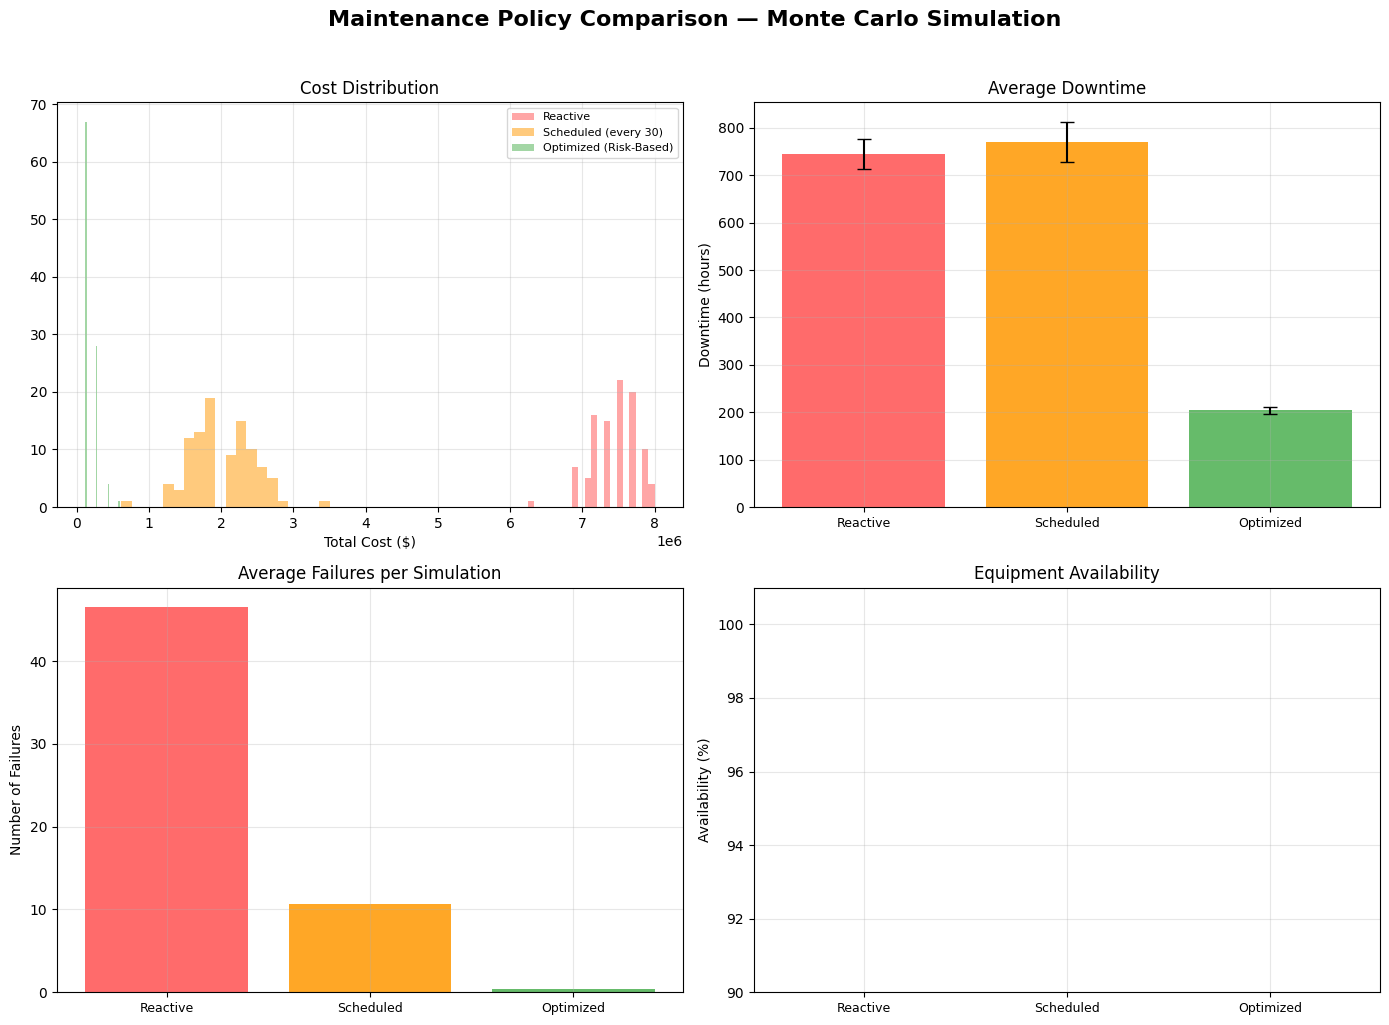

In [ ]:
# Monte Carlo simulation
from src.evaluation.simulation import MaintenanceSimulator

sim = MaintenanceSimulator(n_machines=50, n_periods=100)
sim_df, sim_summary = sim.run_comparison(n_simulations=100)
sim.plot_comparison(sim_df, save_path='simulation_comparison.png')

## 9. Download Results

Download trained models and results back to local machine.

In [ ]:
# Save all results to a zip for download
import shutil
shutil.make_archive('capstone_results', 'zip', '.', 'models/saved')

# In Colab, download the zip:
try:
    from google.colab import files
    files.download('capstone_results.zip')
except ImportError:
    print('Not in Colab. Files saved locally.')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

---
**Project**: FSE 570 Data Science Capstone | Arizona State University